### imports

In [1]:
import csv
import cv2
import time
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### Load in the data

In [2]:
# Read image paths and steering angles from csv file
samples = []     # list of samples, each sample is a list with [ path string, steer angle float, flip augm bool]
STEER_COR  = 0.2 # correction factor for left and right images

with open('data_3/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        samples.append(['./data_3/IMG/' + row[1].split('/')[-1], float(row[3]) + STEER_COR, False])
        samples.append(['./data_3/IMG/' + row[1].split('/')[-1], float(row[3]) + STEER_COR, True])
        samples.append(['./data_3/IMG/' + row[0].split('/')[-1], float(row[3])            , False])
        samples.append(['./data_3/IMG/' + row[0].split('/')[-1], float(row[3])            , True])
        samples.append(['./data_3/IMG/' + row[2].split('/')[-1], float(row[3]) - STEER_COR, False])
        samples.append(['./data_3/IMG/' + row[2].split('/')[-1], float(row[3]) - STEER_COR, True])

tr_samples, va_samples = train_test_split(shuffle(samples), test_size=0.2)


# Get dataset sizes
N_tr = len(tr_samples)
N_va = len(va_samples)
H, W, C = cv2.imread(samples[0][0]).shape

# Define generator to unburden memory
def batch_generator(samples, batch_size=128):

    while 1 == True:
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset : offset+batch_size]

            X_train = np.empty(shape=[0, H, W, C])
            y_train = np.empty(shape=[0])

            for batch_sample in batch_samples:

                if batch_sample[2]:  # augment by flipping
                    b, g, r = cv2.split(cv2.imread(batch_sample[0]))
                    img = np.array(cv2.merge([r, g, b])).reshape([1, H, W, C])
                    X_train = np.append(X_train, img[:, :, ::-1, :], axis=0)
                    y_train = np.append(y_train, -1. * np.array(batch_sample[1]))
                else:  # original
                    b, g, r = cv2.split(cv2.imread(batch_sample[0]))
                    X_train = np.append(X_train, np.array(cv2.merge([r, g, b])).reshape([1, H, W, C]), axis=0)
                    y_train = np.append(y_train, np.array(batch_sample[1]))

            yield shuffle(X_train, y_train)

### Augment the data
depreciated, moved inside generator

### Build the model

In [7]:
# Hyperparameters
EPOCHS     = 10
BATCH_SIZE = 256
DROPOUT    = 0.7  # KEEP PROBABILITY
LRN_RATE   = 0.001
N_CLASSES  = 10
BN_DECAY   = 0.999
BN_EPS     = 0.001
STEER_COR  = 0.2 # defined earlier
TOP_CROP   = 50
BOT_CROP   = 22

In [4]:
# Generators
tr_gen = batch_generator(tr_samples, batch_size=BATCH_SIZE)
va_gen = batch_generator(va_samples, batch_size=BATCH_SIZE)

In [5]:
# model
model = Sequential()
model.add(Cropping2D(cropping=((TOP_CROP, BOT_CROP), (0, 0)), input_shape=(H, W, C)))
model.add(AveragePooling2D())
model.add(Lambda(lambda x: x / 255 - 0.5)) # normalize
# Conv1
model.add(Convolution2D(32, 3, 3, init='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
# Conv2
model.add(Convolution2D(64, 3, 3, init='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(p=0.8))
# Conv3
model.add(Convolution2D(128, 3, 3, init='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(p=0.7))
# Conv4
model.add(Convolution2D(256, 3, 3, init='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p=0.6))
# FC5
model.add(Flatten())
model.add(Dense(256, init='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p=0.5))
# FC6
model.add(Dense(128, init='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p=0.5))
# FC7
model.add(Dense(1, init='glorot_uniform'))

# model.summary()
print('Model build')

Model build


### Reload the model (in case)

In [9]:
model = load_model('second_trained_model.h5')
#model.summary()

# refine hyperparameters for retraining:
EPOCHS     = 5
LRN_RATE   = 0.001

### Train the model

In [10]:
tic = time.time()
adam = optimizers.Adam(lr=LRN_RATE)
model.compile(loss='mse', optimizer=adam)

# save best (validation loss?) trained epoch instance
chckpnt = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
# fit the network
history = model.fit_generator(tr_gen, samples_per_epoch=N_tr, nb_epoch=EPOCHS,
                              validation_data=va_gen, nb_val_samples=N_va, callbacks=[chckpnt])
# load best trained epoch instance
model.load_weights('weights.hdf5')

print('elapsed time: {:.0f} seconds'.format(time.time() - tic))
# after second training round val_loss: 0.0294

Epoch 1/5
4689/4689 [==============================] - 1070s - loss: 0.1037 - val_loss: 0.0966
Epoch 2/5
4689/4689 [==============================] - 842s - loss: 0.0801 - val_loss: 0.1551
Epoch 3/5
4689/4689 [==============================] - 608s - loss: 0.0528 - val_loss: 0.1196
Epoch 4/5
4689/4689 [==============================] - 604s - loss: 0.0397 - val_loss: 0.1348
Epoch 5/5
4689/4689 [==============================] - 589s - loss: 0.0321 - val_loss: 0.1206
elapsed time: 3725 seconds


### Training stats

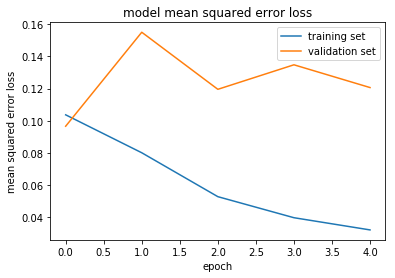

In [11]:
# from Udacity:
# plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('training_curve_third_5_Epochs.jpg')
plt.show()

### Test the model

In [ ]:
pred = model.predict(X_train[:1], verbose=1)
print(pred)

### Save the model

In [12]:
model.save('third_new_set_trained_model.h5')

### Retrain

In [ ]:
##Partly train model
#model.fit(first_training, first_classes, batch_size=32, nb_epoch=20)
#
##Save partly trained model
#model.save('partly_trained.h5')
#
##Load partly trained model
#from keras.models import load_model
#model = load_model('partly_trained.h5')
#
##Continue training
#model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)